# Access community-contributed embeddings

This notebook demonstrates basic access to community-contributed, CELLxGENE-hosted embeddings of the Census.

**IMPORTANT:** this notebook requires tiledbsoma version 1.6 or greater.

## Contents

1. Background
2. Metadata
3. Query cells and load associated embeddings
4. Load embeddings and fetch associated Census data

> ⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).

## Background

This notebook demonstrates access to community-contributed embeddings of the Census. The Census has multiple releases, named by a `census_version`, which normally looks like an ISO date, e.g., `2023-02-01`. A community-contributed embedding is a 2D sparse matrix of cell embeddings _for a given census version_, encoded as a SOMA SparseNDArray.

⚠️ **IMPORTANT:** embeddings are only meaningful in the context of the Census from which they were created. Each embedding contains a metadata field indicating the source Census, suitable for confirming embedding lineage.

## Storage format

Each embedding is encoded as a SOMA SparseNDArray, where:
* dimension 0 (`soma_dim_0`) encodes the cell (obs) `soma_joinid` value
* dimension 1 (`soma_dim_1`) encodes the embedding feature, and is in the range [0, N) where N is the number of featues in the embedding
* data (`soma_data`) is float32

⚠️ **IMPORTANT:** Community-contributed embeddings may embed a subset of the cells in any given Census version. If a cell has an embedding, it will be explicitly stored in the sparse array, _even if the embedding value is zero_. In other words, missing array values values imply that the cell was not embedded, whereas zero valued embeddings are explicitly stored. Put another way, the `nnz` of the embedding array indicate the number of embedded cells, not the number of non-zero values.

The first axis of the embedding array will have the same shape as the corresponding `obs` DataFrame for the Census build and experiment. The second axis of the embedding will have a shape (0, N) where N is the number of features in the embedding.

Embedding values, while stored as a float32, are precision reduced. Currently they are equivalent to a bfloat16, i.e., have 8 bits of exponent and 7 bits of mantissa.


In [1]:
# A few imports and utility functions used throughout this notebook

import json

import cellxgene_census
import numpy as np
import scipy.sparse as sp
import tiledbsoma as soma


# The Census version to utilize
CENSUS_VERSION = "2023-10-23"
EXPERIMENT_NAME = "homo_sapiens"
MEASUREMENT_NAME = "RNA"

# The location of the embedding.  See <cellxgene.cziscience.com> for available contributed embeddings.
EMBEDDING_URI = "s3://cellxgene-contrib-public/contrib/cell-census/soma/2023-10-23/CxG-contrib-1/"

## Query cells and load associated embeddings

This demonstrates several methods to query cells from the Census by `obs` metadata, and then fetch embeddings associated with each cell.

Demos:
1. load the embedding into a dense NumPy array
2. load the embedding into an AnnData `obsm` slot

In [2]:
# Demo 1: select cells from the Census based on obs metadata. Given the resulting cells,
# use their soma_joinids to slice from embedding, and save as a dense NDArray. Cells
# without an embedding will have NaN values in the resulting ndarray.

from cellxgene_census.experimental import get_embedding, get_embedding_metadata
from IPython.display import Markdown


# Query for the cells of interest based upon metadata
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    experiment = census["census_data"][EXPERIMENT_NAME]
    obs_df = (
        experiment.obs.read(
            value_filter="""tissue_general == 'exocrine gland'""",
            column_names=[
                "soma_joinid",
                "cell_type",
                "suspension_type",
                "tissue_general",
            ],
        )
        .concat()
        .to_pandas()
    )

display(obs_df)

# Fetch embedddings for the selected cells, into a 2D NDArray of values
embeddings = get_embedding(CENSUS_VERSION, EMBEDDING_URI, obs_df.soma_joinid.to_numpy())

# Each cell embedding is positionally indexed
display(Markdown("**First few cells, metadata and embedding**"))
display(obs_df.iloc[0:3])
display(embeddings[0:3, 0:4])

,soma_joinid,cell_type,suspension_type,tissue_general
0,8281739,acinar cell of salivary gland,cell,exocrine gland
1,8281740,acinar cell of salivary gland,cell,exocrine gland
2,8281741,naive B cell,cell,exocrine gland
3,8281742,memory B cell,cell,exocrine gland
4,8281743,memory B cell,cell,exocrine gland
...,...,...,...,...
115717,52551944,acinar cell of salivary gland,cell,exocrine gland
115718,52551945,duct epithelial cell,cell,exocrine gland
115719,52551946,acinar cell of salivary gland,cell,exocrine gland
115720,52551947,duct epithelial cell,cell,exocrine gland


**First few cells, metadata and embedding**

,soma_joinid,cell_type,suspension_type,tissue_general
0,8281739,acinar cell of salivary gland,cell,exocrine gland
1,8281740,acinar cell of salivary gland,cell,exocrine gland
2,8281741,naive B cell,cell,exocrine gland


array([[-0.00506592, -0.01348877, -0.03173828, -0.02331543],
       [ 0.02404785, -0.02441406, -0.00595093, -0.0065918 ],
       [ 0.00070572,  0.00187683, -0.04663086, -0.04614258]],
      dtype=float32)

In [3]:
# Demo 2: the same method can be used to query an AnnData from the Census, and
# add the embedding as an `obsm` layer on the AnnData. Cells without an embedding
# will contain NaN in their obsm array.

import cellxgene_census
from cellxgene_census.experimental import get_embedding
import tiledbsoma as soma

with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    experiment = census["census_data"][EXPERIMENT_NAME]
    with experiment.axis_query(
        measurement_name=MEASUREMENT_NAME,
        obs_query=soma.AxisQuery(value_filter="tissue_general in ['spinal cord']"),
        var_query=soma.AxisQuery(coords=(slice(0, 0),)),  # we don't use X data, so minimize load memory & time
    ) as query:
        # Load AnnData and X[raw]
        adata = query.to_anndata(X_name="raw")
        embeddings = get_embedding(CENSUS_VERSION, EMBEDDING_URI, query.obs_joinids())
        adata.obsm["an_embedding"] = embeddings

adata

AnnData object with n_obs × n_vars = 117463 × 1
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'an_embedding'

/home/bruce/cellxgene-census/venv-newtiledb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bruce/cellxgene-census/venv-newtiledb/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bruce/cellxgene-census/venv-newtiledb/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


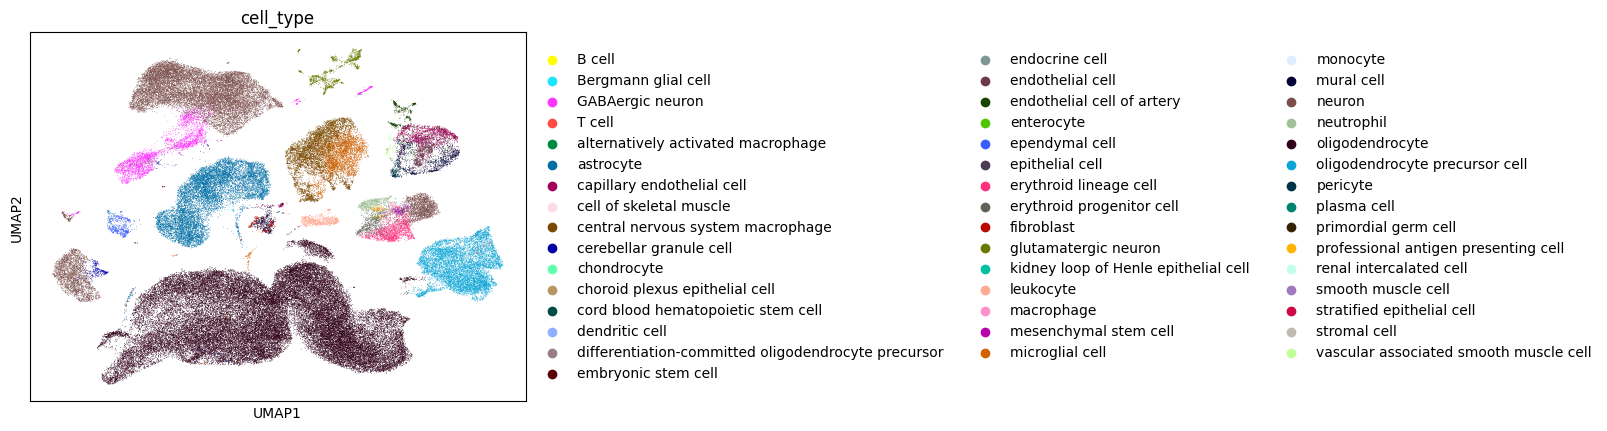

In [4]:
# plot UMAP of embedding with ScanPy
import scanpy

scanpy.pp.neighbors(adata, use_rep="an_embedding")
scanpy.tl.umap(adata)
scanpy.pl.umap(adata, color="cell_type")

## Load embeddings and fetch associated Census data

This method starts with the loaded embedding, and for each embedded cell loads metadata or X data.


In [5]:
# Load a portion of the embedding (caution: embeddings can be quite large)

import cellxgene_census
import numpy as np
import scipy.sparse as sp
import tiledbsoma as soma

# Fetch first 500_000 joinids from the embedding.
# NOTE: will fail if the there are no cells embedded within this obs joinid range
embedding_slice = (slice(500_000),)

emb_data = []
emb_joinids = []
with soma.open(EMBEDDING_URI, context=soma.SOMATileDBContext(tiledb_config={"vfs.s3.region": "us-west-2"})) as E:
    # read embedding and obs joinids for each embedded cell

    for d, (obs_joinids, _) in (
        E.read(coords=embedding_slice).blockwise(axis=0, size=2**20, reindex_disable_on_axis=1).scipy()
    ):
        embedding_presence_mask = d.getnnz(axis=1) != 0
        emb_joinids.append(obs_joinids[embedding_presence_mask])
        emb_data.append(d[embedding_presence_mask, :].toarray())

    # concat
    embedding_data = np.vstack(emb_data)
    embedding_joinids = np.concatenate(emb_joinids)

# Load the associated metadata - in this case, obs.suspension_type
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    experiment = census["census_data"][EXPERIMENT_NAME]
    with experiment.axis_query(
        measurement_name=MEASUREMENT_NAME, obs_query=soma.AxisQuery(coords=(embedding_joinids,))
    ) as query:
        obs_df = query.obs(column_names=["soma_joinid", "suspension_type"]).concat().to_pandas()

# Display the first few cells, and the first few columns of their embeddings
display(obs_df[0:3])
display(embedding_data[0:3, 0:4])

,soma_joinid,suspension_type
0,0,nucleus
1,1,nucleus
2,2,nucleus


array([[-0.00762939, -0.00076675, -0.00047874, -0.03588867],
       [ 0.00405884, -0.00239563,  0.00982666, -0.00946045],
       [ 0.00473022,  0.0135498 , -0.01049805, -0.03051758]],
      dtype=float32)

## Embedding Metadata

Each embedding contains descriptive information stored in the SOMA `metadata` slot, encoded as a JSON string. This metadata includes:

* census_version - the Census which is embedded. It is critical to confirm this matches the Census in use, or the embeddings will be meaningless.
* experiment_name - the Census experiment embedded, e.g., `homo_sapiens` or `mus_musculus`.
* measurement_name - the Census measurement embedded, e.g., `RNA`

There are a variety of other metadata values [documented here](https://github.com/chanzuckerberg/cellxgene-census/blob/main/tools/census_contrib/embedding_metadata.md).

The following example demonstrates how to access and decode the metadata into a Python dictionary.

In [6]:
from cellxgene_census.experimental import get_embedding_metadata

embedding_metadata = get_embedding_metadata(EMBEDDING_URI)

embedding_metadata

{'id': 'CxG-contrib-1',
 'title': 'scGPT: Towards Building a Foundation Model for Single-Cell Multi-omics Using Generative AI',
 'description': 'Utilizing the burgeoning single-cell sequencing data, we have pioneered the construction of a foundation model for single-cell biology, scGPT, which is based on generative pre-trained transformer across a repository of over 33 million cells. Our findings illustrate that scGPT, a generative pre-trained transformer, effectively distills critical biological insights concerning genes and cells. Through the further adaptation of transfer learning, scGPT can be optimized to achieve superior performance across diverse downstream applications.',
 'primary_contact': {'name': 'Bo Wang',
  'email': 'bowang@vectorinstitute.ai',
  'affiliation': 'Bo Wang Lab, University of Toronto'},
 'additional_contacts': [],
 'DOI': '10.1101/2023.04.30.538439',
 'additional_information': '',
 'model_link': 'https://github.com/bowang-lab/scGPT',
 'data_type': 'obs_embedd

A common use case for accessing embedding metadata is the prevention of nonsense results, which will occur when the embeddings were not derived from the Census or experiment in use.

This demonstrates an easy way to grab the embedding metadata and confirm that it matches your expectations.

In [7]:
embedding_metadata = get_embedding_metadata(EMBEDDING_URI)

assert embedding_metadata["census_version"] == CENSUS_VERSION
assert embedding_metadata["experiment_name"] == EXPERIMENT_NAME
assert embedding_metadata["measurement_name"] == MEASUREMENT_NAME

display("all good!")

'all good!'